In [1]:
import os
os.chdir('D:\\Projects\\AppScrip')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords as Stopwords
stopword = list(Stopwords.words('english'))
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pickle

In [2]:
#probability density function and cumulative density function
def pdf_cdf(data,col):
    print(data[col].describe())
    unique_var = data[col].value_counts()
    s = sum(unique_var.values)
    h = unique_var.values/s
    c = np.cumsum(h)
    plt.figure(1)
    plt.figure(figsize=(12,8))
    plt.subplot(221)
    plt.plot(h,label = 'Histogram')
    #plt.xlabel('Index numbers')
    plt.ylabel('Number of Occurances')
    plt.grid()
    plt.legend()
    plt.subplot(222)
    plt.plot(c,label = 'Cumulative distribution')
    plt.grid()
    plt.legend()
    plt.show()
    
def uni(data,col1,col2):
    plt.figure(1)
    plt.figure(figsize=(10,6))
    plt.subplot(221)
    sns.distplot(df[col1]).set_title(col1+' distribution')
    plt.subplot(222)
    sns.distplot(df[col2]).set_title(col2+' distribution')
    plt.show()
    d1 = dict(df[col1].describe())
    d2 = dict(df[col2].describe())
    for key in d1.keys():
        print('\t{}: \t\t{}\t\t\t\t{}'.format(key,round(d1[key],2),round(d2[key],2)))
        
        
def box(data,col1,col2,cat):
    """
    BOX PLOTTING
    four parameter requires:
    data: dataframe
    col1 & col2: for custom column use
    cat: categorical data
    """
    plt.figure(1)
    plt.figure(figsize=(10,6))
    plt.subplot(221)
    sns.boxplot(x = cat, y =col1 , data = data)
    plt.subplot(222)
    sns.boxplot(x = cat, y =col2 , data = data)
    plt.show()

In [3]:
df = pd.read_csv('newsorg.csv', header = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
title          100000 non-null object
description    95700 non-null object
category       100000 non-null object
dtypes: object(3)
memory usage: 2.3+ MB


In [4]:
df.head()

,title,description,category
0,Kiara Advani is a vision in white plunging nec...,Kiara Advani's fashion game has been on point ...,entertainment
1,Pankhuri Awasthy on doing Yeh Rishta Kya Kehla...,Pankhuri Awasthy is all set to make a comeback...,entertainment
2,Posters for Ekta Kapoor's Mangalyaan Series Do...,One poster shows the show’s protagonists flank...,entertainment
3,"Sonakshi Sinha’s new film gets a title, Khanda...","Directed by Shilpi Dasgupta, Sonakshi Sinha’s ...",entertainment
4,Is Samantha Doing Another Cameo For Akkinenis?...,Already Samantha has acted in Nagarjuna's Raju...,entertainment


In [5]:
#Checking the missing value
df.isna().sum()

title             0
description    4300
category          0
dtype: int64

In [4]:
current_row = df.shape[0]
df = df.dropna(axis=0, how = 'any')
print('Null rows drop: ',current_row - df.shape[0])
current_row = df.shape[0]
df = df.drop_duplicates()
print('Duplicates rows drop: ',current_row - df.shape[0])
print('Current data frame shape:', df.shape)

Null rows drop:  4300
Duplicates rows drop:  0
Current data frame shape: (95700, 3)


***TOTAL NUMBER OF NEWS: 95700***
Number of points in class entertainment : 18002 (18.81%) 
Number of points in class general : 15860 (16.57%) 
Number of points in class sports : 14715 (15.38%) 
Number of points in class business : 13579 (14.19%) 
Number of points in class technology : 13428 (14.03%) 
Number of points in class health : 8336 (8.71%) 
Number of points in class science : 6454 (6.74%) 
Number of points in class automotive : 2111 (2.21%) 
Number of points in class ent_regional : 1949 (2.04%) 
Number of points in class ent_tv : 646 (0.68%) 
Number of points in class gaming : 333 (0.35%) 
Number of points in class national : 230 (0.24%) 
Number of points in class international : 57 (0.06%) 


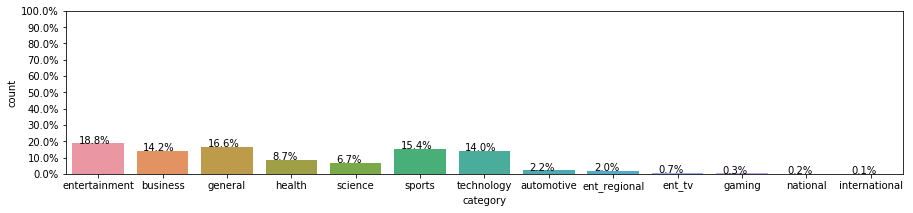

In [7]:
cat_value = dict(df.category.value_counts())
print('***TOTAL NUMBER OF NEWS: {}***'.format(df.shape[0]))
for key, value in cat_value.items():
    print('Number of points in class {} : {} ({}%) '.format(key,value,round(value/957,2)))
total = len(df)
plt.figure(figsize=(15,3))
ax = sns.countplot(x = 'category', data = df)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total),(p.get_x()+0.1, p.get_height()+5))
ax.yaxis.set_ticks(np.linspace(0,total,11))   
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

#### Categories are imbalance

In [8]:
category_list = df.category.unique()
category_encode = {}
for i in range(len(category_list)):
    category_encode[category_list[i]] = i
df.category = df.category.replace(category_encode)

In [9]:
category_encode

{'entertainment': 0,
 'business': 1,
 'general': 2,
 'health': 3,
 'science': 4,
 'sports': 5,
 'technology': 6,
 'automotive': 7,
 'ent_regional': 8,
 'ent_tv': 9,
 'gaming': 10,
 'national': 11,
 'international': 12}

In [10]:
# feature creation
# Number of words
df['num_word_title'] = df['title'].apply(lambda x: len(str(x).split(" ")))
df['num_word_desc'] = df['description'].apply(lambda x: len(str(x).split(" ")))
print('Word count - Done')
# Number of characters
df['title_length'] = df['title'].str.len()
df['description_length'] = df['description'].str.len()
print('character count - Done')
# Number of stopwords
df['stopwords_title'] = df['title'].apply(lambda x: 
                                             len([x for x in x.split() if x in stopword]))
df['stopwords_desc'] = df['description'].apply(lambda x: 
                                                  len([x for x in x.split() if x in stopword]))
print('Stopword count - Done')

# Number of numerics
# Not useful in the respective dataset
# df['numerics_title'] = df['title'].apply(lambda x: 
#                                             len([x for x in x.split() if x.isdigit()]))
# df['numerics_desc'] = df['description'].apply(lambda x: 
#                                                  len([x for x in x.split() if x.isdigit()]))
# print('Numeric count - Done')
# # Number of uppercase words
# df['upper_title'] = df['title'].apply(lambda x: 
#                                          len([x for x in x.split() if x.isupper()]))
# df['upper_desc'] = df['description'].apply(lambda 
#                                               x: len([x for x in x.split() if x.isupper()]))
# print('uppercase count - Done')

Word count - Done
character count - Done
Stopword count - Done


# Univariate analysis on Numrical features

In [11]:
df.describe()

,category,num_word_title,num_word_desc,title_length,description_length,stopwords_title,stopwords_desc
count,95700.000000,95700.000000,95700.000000,95700.000000,95700.000000,95700.000000,95700.000000
mean,3.061578,14.800951,27.016270,87.802811,160.616562,2.214734,9.284044
std,2.417746,3.608747,11.037948,21.016790,64.158348,1.809508,4.863101
min,0.000000,3.000000,1.000000,14.000000,1.000000,0.000000,0.000000
25%,1.000000,12.000000,19.000000,73.000000,114.000000,1.000000,6.000000
50%,3.000000,15.000000,26.000000,86.000000,155.000000,2.000000,9.000000
75%,5.000000,17.000000,35.000000,102.000000,208.000000,3.000000,12.000000
max,12.000000,59.000000,61.000000,344.000000,260.000000,22.000000,32.000000


<Figure size 432x288 with 0 Axes>

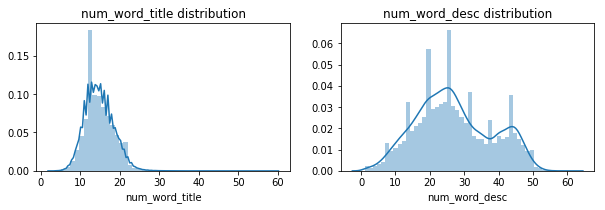

	count: 		95700.0				95700.0
	mean: 		14.8				27.02
	std: 		3.61				11.04
	min: 		3.0				1.0
	25%: 		12.0				19.0
	50%: 		15.0				26.0
	75%: 		17.0				35.0
	max: 		59.0				61.0


<Figure size 432x288 with 0 Axes>

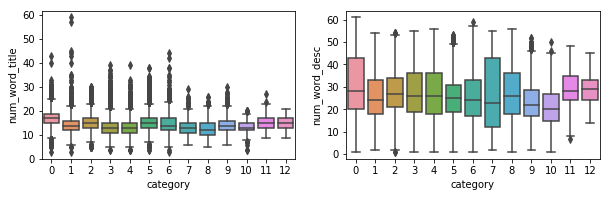

In [12]:
uni(df,'num_word_title','num_word_desc')
box(df,'num_word_title','num_word_desc', 'category')

<Figure size 432x288 with 0 Axes>

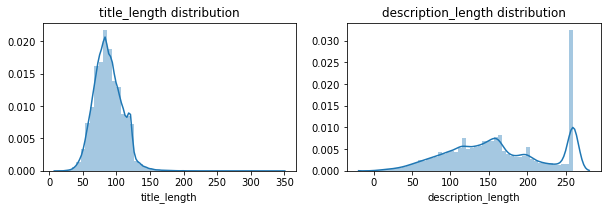

	count: 		95700.0				95700.0
	mean: 		87.8				160.62
	std: 		21.02				64.16
	min: 		14.0				1.0
	25%: 		73.0				114.0
	50%: 		86.0				155.0
	75%: 		102.0				208.0
	max: 		344.0				260.0


<Figure size 432x288 with 0 Axes>

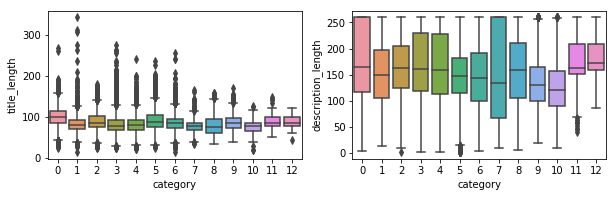

In [13]:
uni(df,'title_length','description_length')
box(df,'title_length','description_length', 'category')

#### From the above analysis we can conclude that the above features 'num_word_title' , 'num_word_desc' ,'title_length','description_length' has same amount of variance with is useless for the classification algorithm
### Point to be consider.
- Minimum words in the title is 3 and Minimum words in description is 1, due to this there won't be enough information to predict the respective classification<br> Drop the news/obersvation which has low word count

In [13]:
symbols = ['!', '"', '#', '$', '%', '(', ')', '*', '+', ',',
           '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[',
           '\\', ']', '^', '_', '`', '{', '|', '}', '~','&',"'s"]


def text_cleaning(text):
    """
    text: enter the text/string
    returns: modified text/clean text
    """
    text = str(text)
    text =text.lower()
    for symbol in symbols: text = text.replace(symbol,'') # Replacing all symbols
    text = text.replace('  ', ' ')
    text = ' '.join(word for word in text.split() 
                    if word not in stopword and word.isalpha()==True and len(word)>2)
    return text

In [14]:
#TEXT PROCESSING FOR BAG OF WORDS AND TF-IDF 
#Lower case
df.title = df.title.str.lower()
df.description = df.description.str.lower()
#tag removal
df.title = df.title.str.replace('<[^<]+?>','')
df.description = df.description.str.replace('<[^<]+?>','')
#Removing the numbers
df.title = df.title.str.replace('\d+', '')
df.description = df.description.str.replace('\d+', '')
# TEXT CLEANING
df['process_title'] = df['title'].apply(text_cleaning)
df['process_description'] = df['description'].apply(text_cleaning)

In [16]:
df.to_csv('process.csv', index=False)

In [17]:
df = pd.read_csv('process.csv',header = 0)

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
count_vec = CountVectorizer().fit(df.process_title)
x_title = count_vec.transform(df.process_title)

#Saving the model
filename = 'title_vector.sav'
pickle.dump(count_vec, open(filename, 'wb'))
print('Model Saved')


Model Saved


In [17]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_vec = TfidfTransformer().fit(x_title)
x_title_tfidf = tfidf_vec.transform(x_title)

#Saving the model
filename = 'title_tfidf.sav'
pickle.dump(tfidf_vec, open(filename, 'wb'))
print('Model Saved')


Model Saved


In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(x_title_tfidf, df.category, random_state = 42,
                                                   stratify = df.category)

In [24]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train,y_train)
nb_predict = clf.predict(X_test)

accuracy 0.8222361546499477
Macro 0.5085003314099487
Micro 0.8222361546499477


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


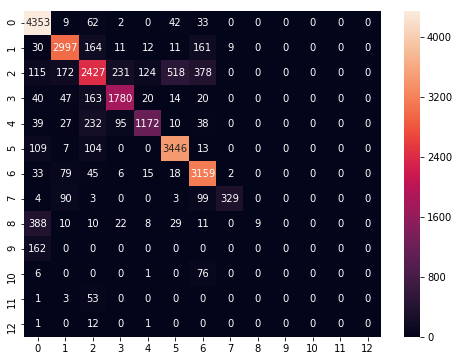

In [25]:
print("accuracy",accuracy_score(y_test,nb_predict))
print("Macro",f1_score(y_test,nb_predict, average = 'macro'))
print('Micro',f1_score(y_test,nb_predict, average = 'micro'))
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test,nb_predict), annot=True,fmt='d')
plt.show()

#### By checking the aboving confusion metric<br>categories like ent_regional and ent_tv was predicted to be *"entertainment"* 
##### - international and national was predicted to be 'General'
##### - Gaming was predicted to be "Technology"
#### All the above error seems to be correct as Gaming news has technological factor and<br>ent_regional and ent_tv also has the similar news tone same as entertainmnet
#### lets try two different approches to counter this issue.
- <h4>using weight in machine learning algorithm or using upsampling.</h4>
- <h4>Combining the similar Categories</h4>

### But main problems is with Class like "General" as lot's of the above general news was predicted to be of 'entertainment', 'health', 'science', 'sports' and 'technology'

# Training and testing the models

In [20]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(x_title_tfidf, df.category,
                                                    stratify=df.category,test_size=0.20)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

In [21]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 61248
Number of data points in test data: 19140
Number of data points in cross validation data: 15312


In [22]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    labels = [0,1,2,3,4,5,6,7,8,9,10,11,12]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*30, "Confusion matrix", "-"*30)
    plt.figure(figsize=(12,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt="d", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*30, "Precision matrix", "-"*30)
    plt.figure(figsize=(12,5))
    sns.heatmap(B, annot=True, cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))

    print("-"*30, "Recall matrix"    , "-"*30)
    plt.figure(figsize=(12,5))
    sns.heatmap(A, annot=True, cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

### K Nearest Neighbour Classification(title)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, Fut

log_loss for k =  1 is 0.7990783197875357
log_loss for k =  3 is 0.6169081966308011
log_loss for k =  5 is 0.5780465262005825
log_loss for k =  7 is 0.5646328514392525
log_loss for k =  9 is 0.5573708918833681
log_loss for k =  11 is 0.5561568984787094
log_loss for k =  13 is 0.5566500682804058


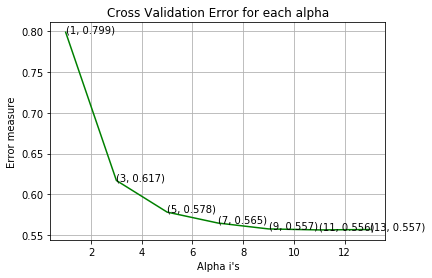

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Model Saved
For values of best alpha =  11 The train log loss is: 0.4797157695690716
For values of best alpha =  11 The cross validation log loss is: 0.5561568984787094
For values of best alpha =  11 The test log loss is: 0.5678761122617277
Number of misclassified points  17.074190177638453
------------------------------ Confusion matrix ------------------------------


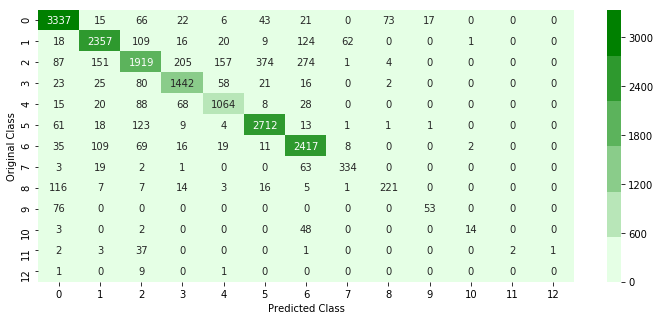

------------------------------ Precision matrix ------------------------------


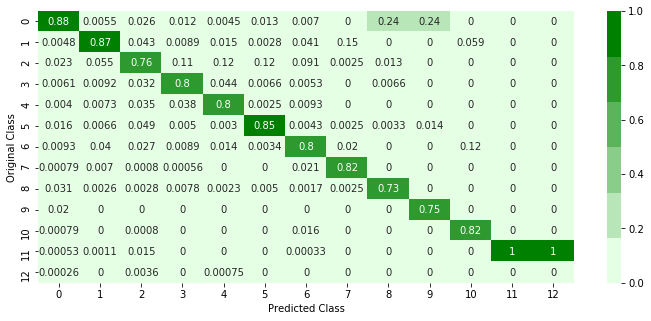

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
------------------------------ Recall matrix ------------------------------


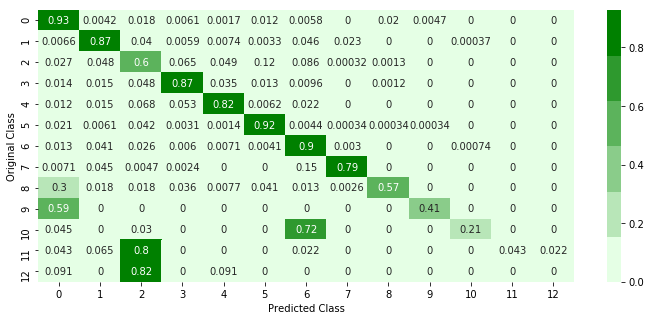

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
accuracy 0.8292580982236155
Macro 0.6320000686981879
Micro 0.8292580982236155


In [31]:
alpha = [x for x in range(1, 15, 2)]
cv_log_error_array=[]
for i in alpha:
    k_cfl=KNeighborsClassifier(n_neighbors=i)
    k_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=k_cfl.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for k = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


k_cfl=KNeighborsClassifier(n_neighbors=alpha[best_alpha])
k_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
#Saving the model
filename = 'title_knn.sav'
pickle.dump(sig_clf, open(filename, 'wb'))
print('Model Saved')

predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
predict_knn = sig_clf.predict(X_test)
plot_confusion_matrix(y_test, predict_knn)
print("accuracy",accuracy_score(y_test, predict_knn))
print("Macro",f1_score(y_test, predict_knn, average = 'macro'))
print('Micro',f1_score(y_test, predict_knn, average = 'micro'))

### Logistic Regression

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


log_loss for c =  1e-05 is 1.5283255788669525
log_loss for c =  0.0001 is 1.1943155179715461
log_loss for c =  0.001 is 0.8145387238408766
log_loss for c =  0.01 is 0.7758572931374159
log_loss for c =  0.1 is 0.6641300162638658
log_loss for c =  1 is 0.5030397634038357
log_loss for c =  10 is 0.445504662963606
log_loss for c =  100 is 0.4802838326929131
log_loss for c =  1000 is 0.5419274779772241


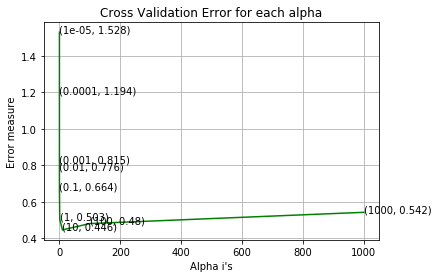

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning

Model Saved
log loss for train data 0.2835254140018905
log loss for cv data 0.445504662963606
log loss for test data 0.45757164504162734
Number of misclassified points  13.991640543364682
------------------------------ Confusion matrix ------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


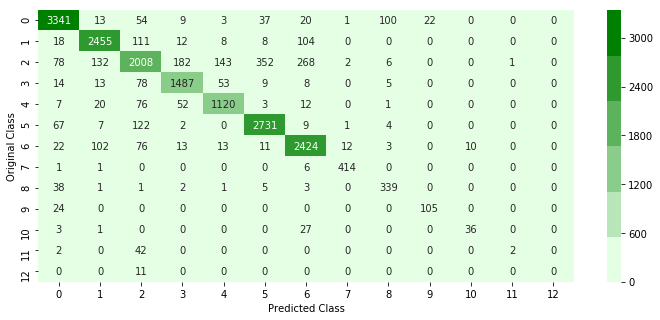

------------------------------ Precision matrix ------------------------------


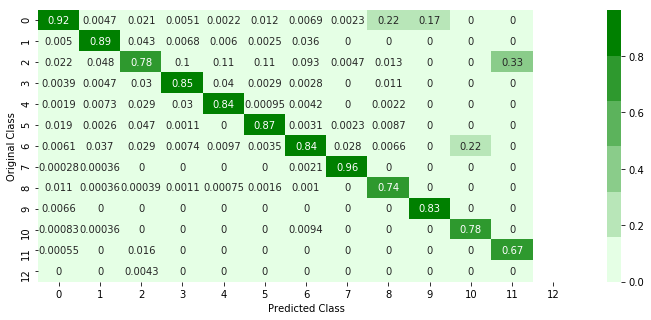

Sum of columns in precision matrix [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. nan]
------------------------------ Recall matrix ------------------------------


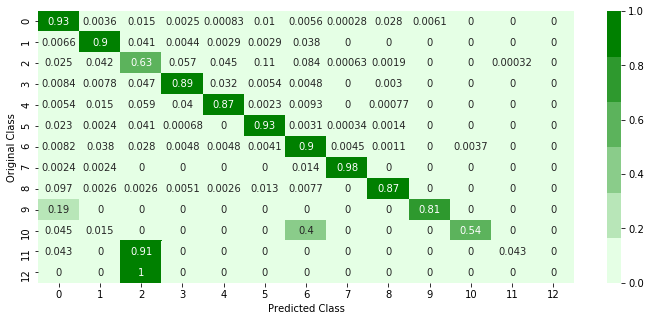

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
accuracy 0.8600835945663532
Macro 0.7168883866789848
Micro 0.8600835945663532


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [33]:
alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array=[]
for i in alpha:
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_train, y_train)
pred_y=sig_clf.predict(X_test)

#Saving the model
filename = 'title_lg.sav'
pickle.dump(sig_clf, open(filename, 'wb'))
print('Model Saved')

predict_y = sig_clf.predict_proba(X_train)
print ('log loss for train data',log_loss(y_train, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv)
print ('log loss for cv data',log_loss(y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print ('log loss for test data',log_loss(y_test, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_lg = sig_clf.predict(X_test)
plot_confusion_matrix(y_test,predict_lg )
print("accuracy",accuracy_score(y_test, predict_lg))
print("Macro",f1_score(y_test, predict_lg, average = 'macro'))
print('Micro',f1_score(y_test, predict_lg, average = 'micro'))

## XGBClassifier

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, Fut

log_loss for c =  10 is 1.292879355553777
log_loss for c =  50 is 1.0535384635300962
log_loss for c =  100 is 0.9409513302150055
log_loss for c =  500 is 0.7001234655070313
log_loss for c =  1000 is 0.6304416847167548


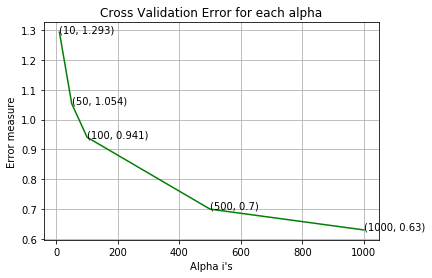

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Model Saved
For values of best alpha =  1000 The train log loss is: 0.5050294787861666
For values of best alpha =  1000 The cross validation log loss is: 0.6304416847167548
For values of best alpha =  1000 The test log loss is: 0.6276867044621576
Number of misclassified points  18.051201671891327
------------------------------ Confusion matrix ------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


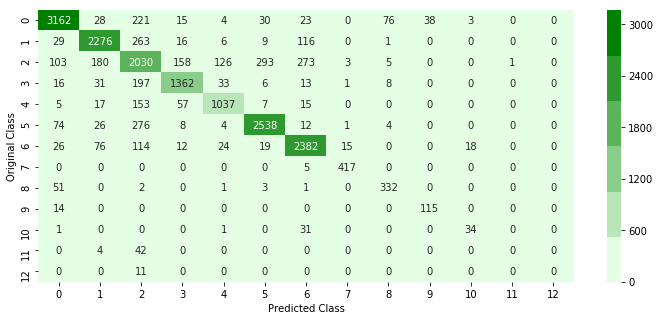

------------------------------ Precision matrix ------------------------------


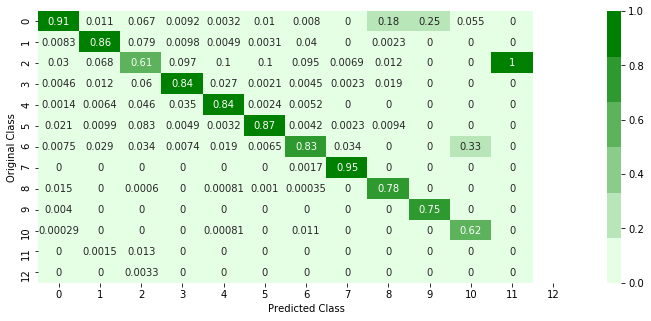

Sum of columns in precision matrix [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. nan]
------------------------------ Recall matrix ------------------------------


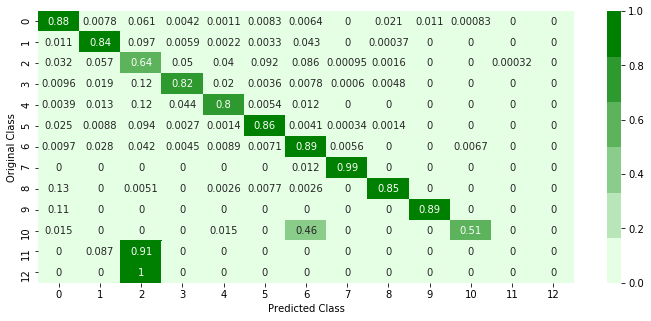

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
accuracy 0.8194879832810867
Macro 0.6846213303500045
Micro 0.8194879832810867


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [28]:
alpha=[10,50,100,500,1000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1)
    x_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

#Saving the model
filename = 'title_xg.sav'
pickle.dump(sig_clf, open(filename, 'wb'))
print('Model Saved')

predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
predict_xb = sig_clf.predict(X_test)
plot_confusion_matrix(y_test,predict_xb )
print("accuracy",accuracy_score(y_test,predict_xb))
print("Macro",f1_score(y_test,predict_xb , average = 'macro'))
print('Micro',f1_score(y_test,predict_xb , average = 'micro'))

In [30]:
print("accuracy",accuracy_score(y_test,predict_xb))
print("Macro",f1_score(y_test,predict_xb , average = 'macro'))
print('Micro',f1_score(y_test,predict_xb , average = 'micro'))

accuracy 0.8194879832810867
Macro 0.6846213303500045
Micro 0.8194879832810867


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# 2<sup>nd</sup> Method (Combining categories)

In [16]:
# {'entertainment','ent_regional', 'ent_tv': 0,
#  'business': 1,
#  'general', 'national', 'international': 2,
#  'health': 3,
#  'science': 4,
#  'sports': 5,
#  'technology', 'gaming': 6,
#  'automotive': 7,}

In [ ]:
category_encode = {8:1,9:1,11:2,12:2,10:6}
df.category = df.category.replace(category_encode)

In [ ]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    labels = [0,1,2,3,4,5,6,7]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*30, "Confusion matrix", "-"*30)
    plt.figure(figsize=(12,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt="d", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*30, "Precision matrix", "-"*30)
    plt.figure(figsize=(12,5))
    sns.heatmap(B, annot=True, cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))

    print("-"*30, "Recall matrix"    , "-"*30)
    plt.figure(figsize=(12,5))
    sns.heatmap(A, annot=True, cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

In [ ]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(x_description_tfidf, df.category,
                                                    stratify=df.category,test_size=0.20)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)


print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

# Logistic Regression

In [ ]:
alpha = [10 ** x for x in range(-4, 4)]
cv_log_error_array=[]
for i in alpha:
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_train, y_train)
pred_y=sig_clf.predict(X_test)

#Saving the model
filename = 'title_lg2.sav'
pickle.dump(sig_clf, open(filename, 'wb'))
print('Model Saved')

predict_y = sig_clf.predict_proba(X_train)
print ('log loss for train data',log_loss(y_train, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv)
print ('log loss for cv data',log_loss(y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print ('log loss for test data',log_loss(y_test, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_lg = sig_clf.predict(X_test)
plot_confusion_matrix(y_test,predict_lg )
print("accuracy",accuracy_score(y_test, predict_lg))
print("Macro",f1_score(y_test, predict_lg, average = 'macro'))
print('Micro',f1_score(y_test, predict_lg, average = 'micro'))

# XGBClassifier

In [ ]:
alpha=[10,50,100,500]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1)
    x_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

#Saving the model
filename = 'title_xg2.sav'
pickle.dump(sig_clf, open(filename, 'wb'))
print('Model Saved')

predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
predict_xb = sig_clf.predict(X_test)
plot_confusion_matrix(y_test,predict_xb )
print("accuracy",accuracy_score(y_test,predict_xb))
print("Macro",f1_score(y_test,predict_xb , average = 'macro'))
print('Micro',f1_score(y_test,predict_xb , average = 'micro'))